<a href="https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/05_aipi590_xai_livermrcnnmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# AIPI 590 - XAI | Assignment 05

#Description: Explainable AI Part 2

This notebook is for exploring locally explainable AI methods such as shap, lime, and anchors. The dataset is one I have taken part in creating, and is a publically available dataset of Abdominal MRI images. I have trained a DenseNet121 model to identify the type of MRI image based on the pixel-data (with 19 classes corresponding to types of MRI images, including labels of 'adc', 'arterial', 'dynamic_late', 't2', 'dwi', 't2', 'dwi', 'dixon_fat', 'hepatobiliary', 'hepatobiliary', 'in_phase', 'in_phase', 'dynamic_equilibrium', 'loc', 'mrcp', 'opposed_phase', 'opposed_phase', 'portal_venous', and 't1_fat_sat').

## Chad Miller

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/05_aipi590_xai_livermrcnnmodel.ipynb)

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  !git clone -b colabversion 'https://github.com/mille055/stanford_project.git'
  !git clone 'https://github.com/mille055/AIPI590-XAI.git'
  !pip install -r /content/AIPI590-XAI/requirements.txt

Cloning into 'stanford_project'...
remote: Enumerating objects: 2922, done.
remote: Counting objects: 100% (677/677), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 2922 (delta 477), reused 601 (delta 414), pack-reused 2245 (from 1)
Receiving objects: 100% (2922/2922), 384.51 MiB | 13.70 MiB/s, done.
Resolving deltas: 100% (2077/2077), done.
Cloning into 'AIPI590-XAI'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 309 (delta 79), reused 0 (delta 0), pack-reused 191 (from 1)
Receiving objects: 100% (309/309), 33.53 MiB | 13.06 MiB/s, done.
Resolving deltas: 100% (195/195), done.
  Cloning https://github.com/christophM/rulefit.git to /tmp/pip-install-_6pj3e32/rulefit_78ca005855934b879a1cd4bd5b7f7eed
  Running command git clone --filter=blob:none --quiet https://github.com/christophM/rulefit.git /tmp/pip-install-_6pj3e32/rulefit_78ca005855934b879a1cd4bd5b7f7

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
from google.colab import files

import alibi
from alibi.explainers import AnchorImage
from skimage.transform import resize
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

import warnings

warnings.filterwarnings("ignore")

from PIL import Image


In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'

    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2, data_transforms3, data_transforms4

from model_container import ModelContainer



Mounted at /content/gdrive


In [6]:
# get the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Download Datasets and DataLoaders

In [7]:
# have already pickled the datasets and just loading here
train_df = pd.read_pickle('/content/gdrive/MyDrive/train_df.pkl')
val_df = pd.read_pickle('/content/gdrive/MyDrive/val_df.pkl')
test_df = pd.read_pickle('/content/gdrive/MyDrive/test_df.pkl')
val_ran_df = pd.read_pickle('/content/gdrive/MyDrive/val_ran_df.pkl')

In [8]:
# Get the data loaders
# dataloaders - vanilla, no augmentation just cropping and resizing, number channels to 1, and to tensor
# dataloaders2 - some augmentation (color jitter)
# dataloaders3 - some augmentation (color jitter) as well as use of a gamma filter with parameter = 2 to highlight bright pixels
# dataloaders4 - some augmentation (color jitter) as well as use of a gamma filter with parameter = 0.5 for comparison

batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
train_loader3, val_loader3, test_loader3, dataset_sizes3 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms3)
train_loader4, val_loader4, test_loader4, dataset_sizes4 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms4)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}
dataloaders3 = {'train': train_loader3, 'val': val_loader3, 'test': test_loader3}
dataloaders4 = {'train': train_loader4, 'val': val_loader4, 'test': test_loader4}


Brief EDA

In [9]:
# sizes of train, val, and test datasets
train_df.shape, val_df.shape, test_df.shape

((1369, 31), (354, 31), (432, 31))

In [10]:
# list of the classes

cls_list = []
for cls in classes:
    cls_list.append(abd_label_dict[str(cls)]['short'])
print(cls_list)

['adc', 'arterial', 'dynamic_late', 't2', 'dwi', 't2', 'dwi', 'dixon_fat', 'hepatobiliary', 'hepatobiliary', 'in_phase', 'in_phase', 'dynamic_equilibrium', 'loc', 'mrcp', 'opposed_phase', 'opposed_phase', 'portal_venous', 't1_fat_sat']


In [13]:
# distribution of classes in the test dataset
t_df = test_df.copy()
t_df['text_label'] = t_df['label'].apply(lambda x: abd_label_dict[str(x)]['short'])
t_df['text_label'].value_counts()


text_label
t2                     64
arterial               61
t1_fat_sat             47
dwi                    43
dixon_fat              29
mrcp                   28
in_phase               23
opposed_phase          23
dynamic_equilibrium    22
adc                    21
loc                    21
portal_venous          20
dynamic_late           17
hepatobiliary          13
Name: count, dtype: int64

Displaying one of each class of image

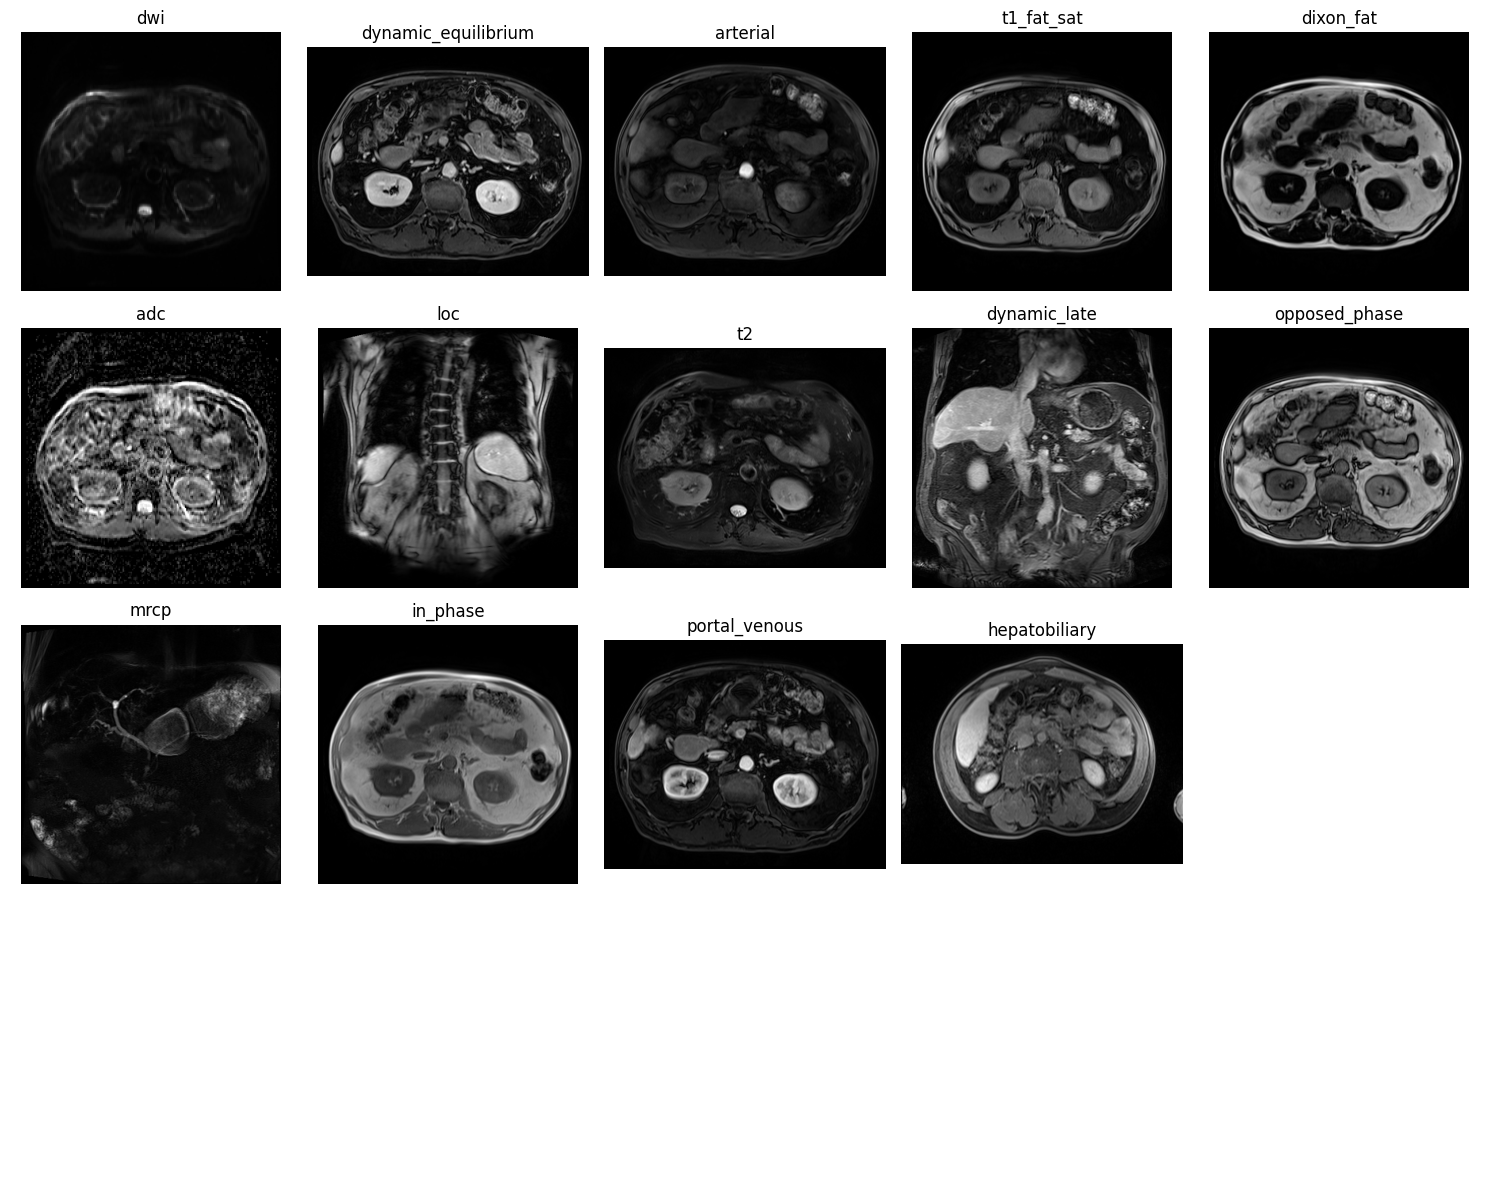

In [18]:

# Get one example of each type of image
each_type = t_df.groupby('text_label').head(1)

# Set up the number of rows and columns for the grid and create a figure
n_cols = 5
n_rows = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Loop through each image and its corresponding axis
for idx, (ax, (_, row)) in enumerate(zip(axes, each_type.iterrows())):
    image_path = row['fname']
    label = row['label']
    named_label = abd_label_dict[str(label)]['short']

    # Load the DICOM image
    ds = pydicom.dcmread(image_path)
    image = ds.pixel_array

    # Display the image on the corresponding axis
    ax.imshow(image, cmap='gray')
    ax.set_title(named_label)
    ax.axis('off')  # Turn off the axis labels/ticks

# Hide any remaining empty subplots
for ax in axes[idx + 1:]:
    ax.axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## DenseNet model for image classification
I previously trained a DenseNet121 model using transfer learning on a dataset of Abdominal MRI images to predict the type of MRI image (out of 19 classes: 'adc', 'arterial', 'dynamic_late', 't2', 'dwi', 't2', 'dwi', 'dixon_fat', 'hepatobiliary', 'hepatobiliary', 'in_phase', 'in_phase', 'dynamic_equilibrium', 'loc', 'mrcp', 'opposed_phase', 'opposed_phase', 'portal_venous', 't1_fat_sat'). The train dataset contains 1369 examples and the test dataset contains 432 examples. A description of the dataset and the model can be found at https://pubmed.ncbi.nlm.nih.gov/38860997/

In [20]:

# Load the saved model
model = CustomDenseNet(num_classes=len(classes))
model.load_state_dict(torch.load('/content/gdrive/MyDrive/best_model_cnn_0930.pth'))
model.to(device)
model.eval()


CustomDenseNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [21]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):


    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)

    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))


    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("/content/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')

    return cm



[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.90      0.85      0.87        61
           6       0.89      1.00      0.94        17
           7       0.96      1.00      0.98        22
           8       0.95      0.98      0.97        43
           9       0.98      0.95      0.96        42
          11       1.00      1.00      1.00        29
          12       0.33      0.10      0.15        10
          13       1.00      0.33      0.50         3
          14       0.95      0.83      0.88        23
          16       0.68      0.68      0.68        22
          17       1.00      0.95      0.98        21
          18       1.00      0.96      0.98        28
          19       0.82      1.00      0.90        23
          23       0.44      0.60      0.51        20
          25       0.92   

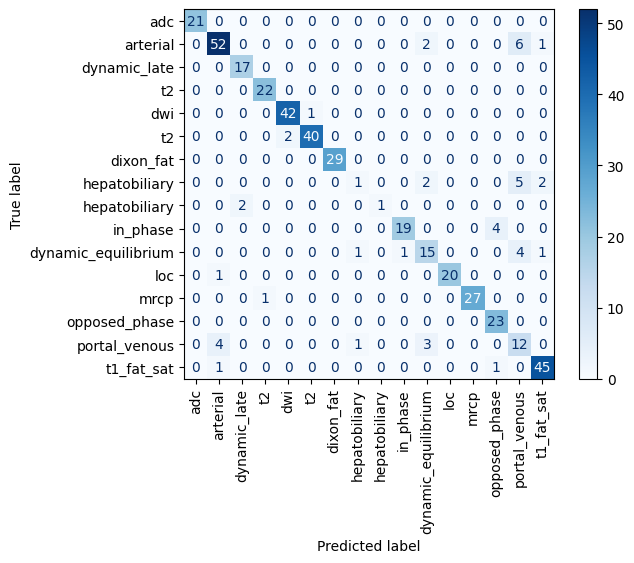

<Figure size 2500x2500 with 0 Axes>

In [22]:
# This only needs to be run to display the classifier in the notebook. Commenting it out
# because it takes a long time and is not part of the main point of this notebook.

# # Make predictions on the test set
# test_predictions = []
# test_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)

#     with torch.no_grad():
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         test_predictions.append(predicted.cpu().numpy())
#         test_labels.append(labels.cpu().numpy())

# test_predictions = np.concatenate(test_predictions, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)

# # Evaluate the model's performance on the test set
# cm = display_and_save_results2(test_predictions, test_labels, classes, fn='test_results', saveflag=True)


# Explainable AI
We will look at the post hoc methods to get insights into the model predictions.

## Lime (Local Interpretable Model-agnostic Explanations)
This is often preferred for interpretability tasks in image classification due to its ability to work with any black-box model, including DenseNet. There is no need to modify the model or rely on internal gradients (unlike some SHAP methods), making LIME highly flexible. LIME operates by dividing the image into superpixels, which are groups of adjacent pixels that often share similar visual characteristics. By perturbing these superpixels and analyzing the effect on the model’s output, LIME offers an explanation of the regions in the image which are most important for the prediction, useful when you want to understand individual classifications and explore specific image regions responsible for the decision.


In [24]:
# Prediction function for LIME
def lime_predict_fn(images, model=model):
    # Convert images to tensors and preprocess them for the model
    images = torch.tensor(images.transpose(0, 3, 1, 2)).float().to(device)  # Convert to (batch_size, channels, height, width)

    # Get model outputs
    with torch.no_grad():
        outputs = model(images)

    # Return softmax predictions
    return torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

class: late_arterial


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


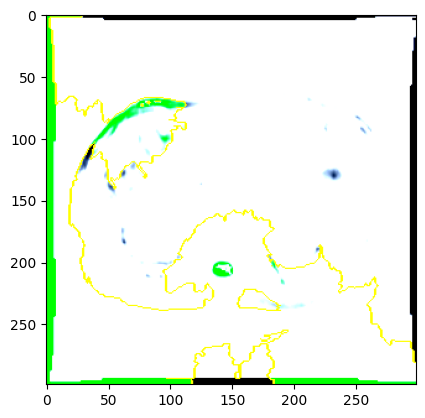

class: late_arterial


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


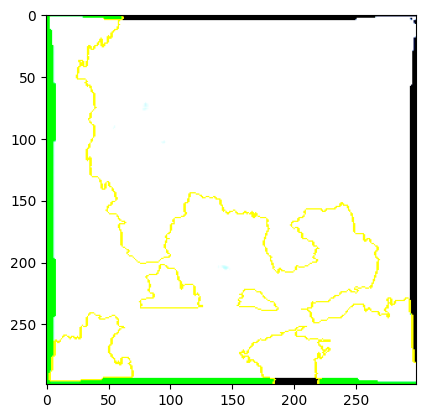

class: hepatobiliary


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


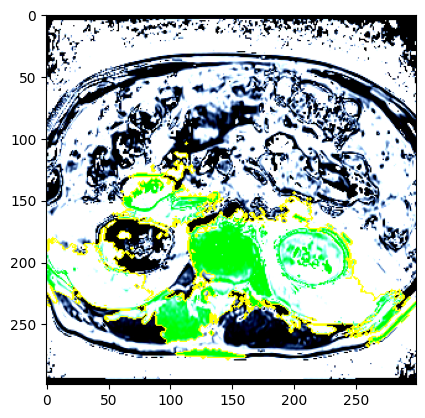

class: other


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


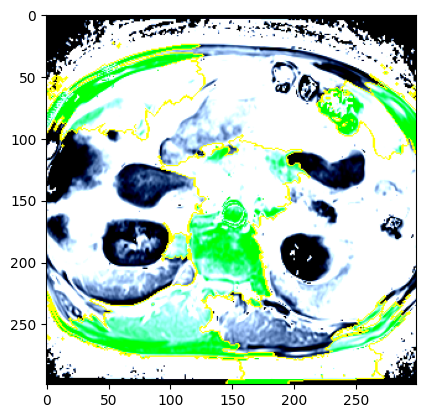

class: mrcp


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


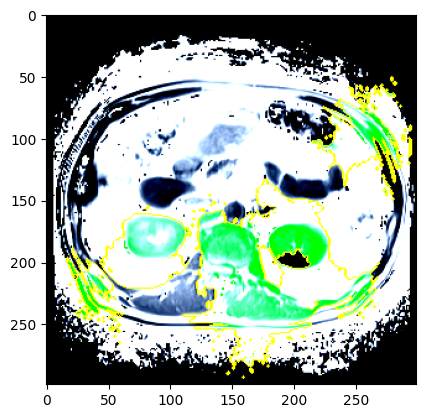

class: t2


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


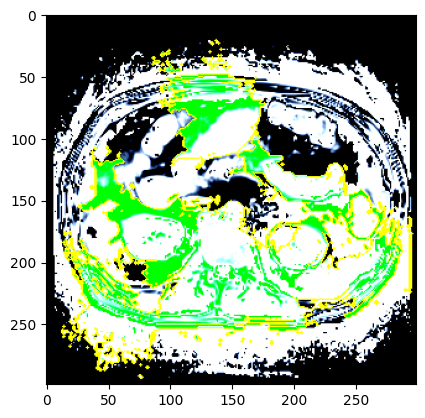

class: adc


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


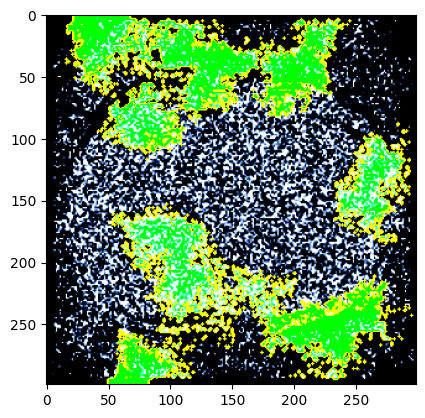

class: hepatobiliary


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


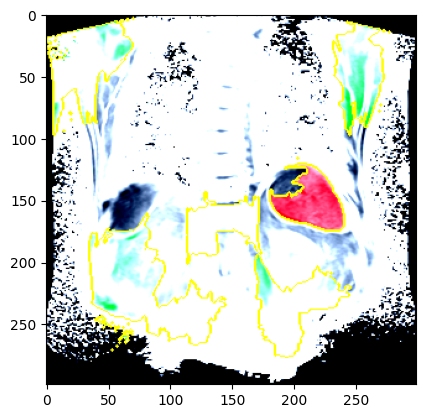

class: arterial_sub


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


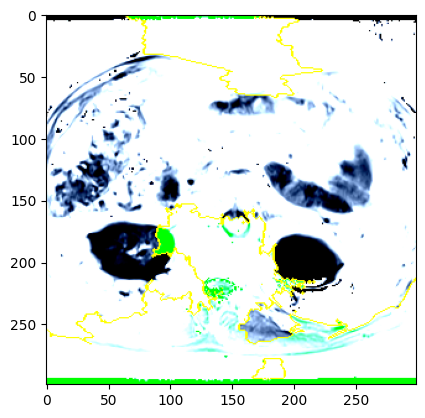

class: arterial


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


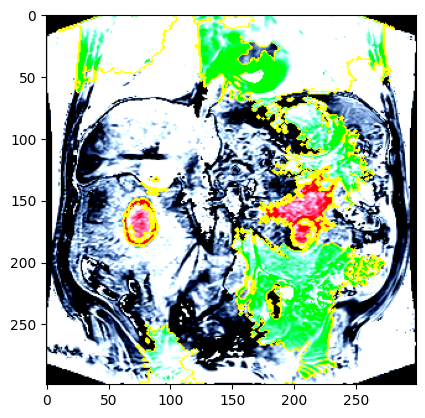

class: arterial_sub


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


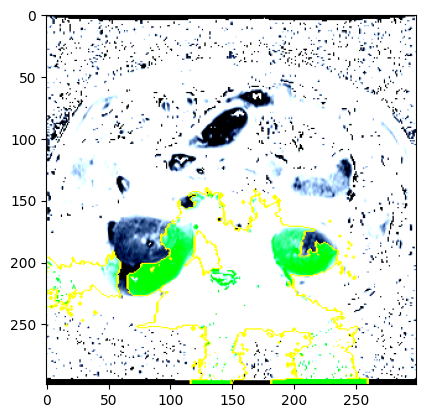

class: in_phase


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


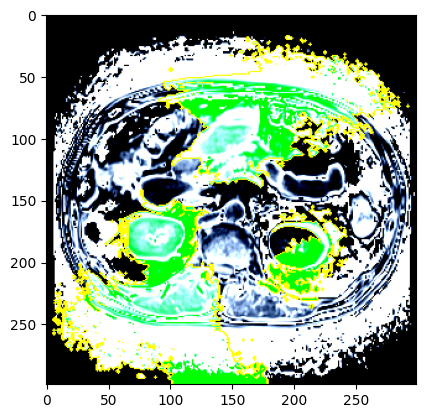

class: in_phase


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


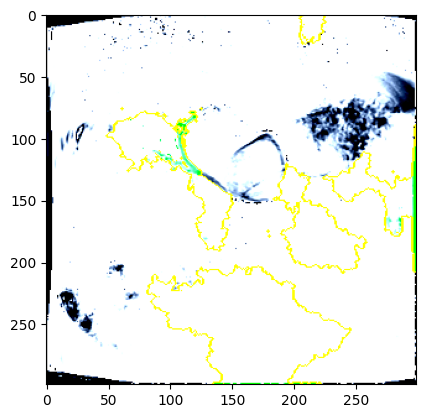

class: mrcp


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


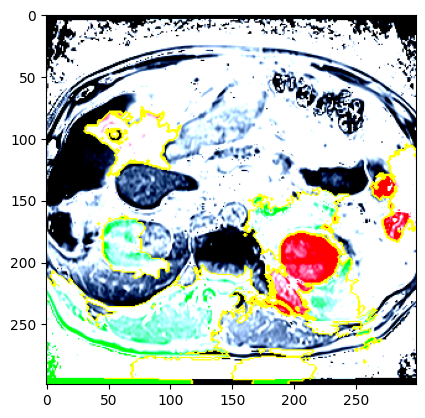

class: other


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


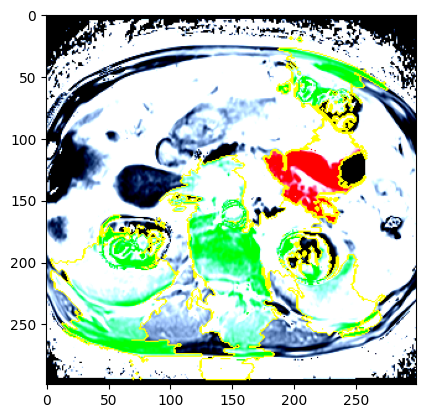

class: early_arterial


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(7)


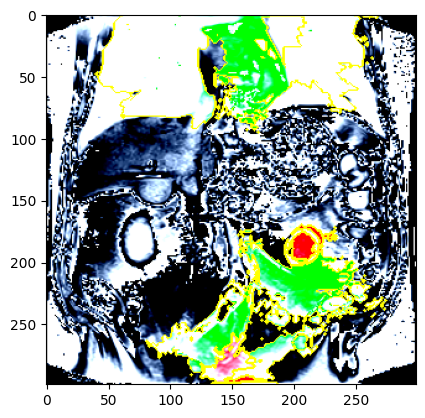

In [40]:
# Initialize the LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Select an image from the test set
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)


# Specify the mean and std used during normalization in the data loader
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Get imageS and convert it to (height, width, channels)
for idx in range(inputs.shape[0]):
    image = inputs[idx].cpu().numpy().transpose((1,2,0))
    text_label = abd_label_dict[str(labels[idx].item())]['short']
    print('class:', text_label)

    # Run LIME explanation on the image
    explanation = explainer.explain_instance(image, lime_predict_fn, top_labels=5, hide_color=0, num_samples=1000)

    # Get the image and mask for the top class label
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)



    # Visualize the explanation using mark_boundaries
    print(labels[5])
    plt.imshow(mark_boundaries(temp, mask))
    plt.show()

Interpretation: Yellow or green superpixel regions represent positive contributions to the predicted class. These parts of the image were important for the model to classify the image as the predicted label. Absent regions or dimmed areas were less important or irrelevant to the model's decision. Red regions correspond to negative contributions, and serve to pull the model away from the predicted class.

On these images, one thing that that makes interpretation a little more difficult is the fact that the underlying image plotted is the processed image rather than the original image. Consequently, the images do not appear as one would be acustomed to viewing that type of image. However, the contributions in the overlay mask are still able to be correlated with the appopropriate location and anatomy, and remain helpful in assessing which portions of he image contribute most to the prediction.

On the t2 image, the green regions correspond to the perinephric fat and portions of the abdominal wall musculature. However, one would expect the most important pixels would be the h2 hyperintense signal in the spinal canal (or any other fluid-containing structure).

Now will try to plot the mask with the original images...

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

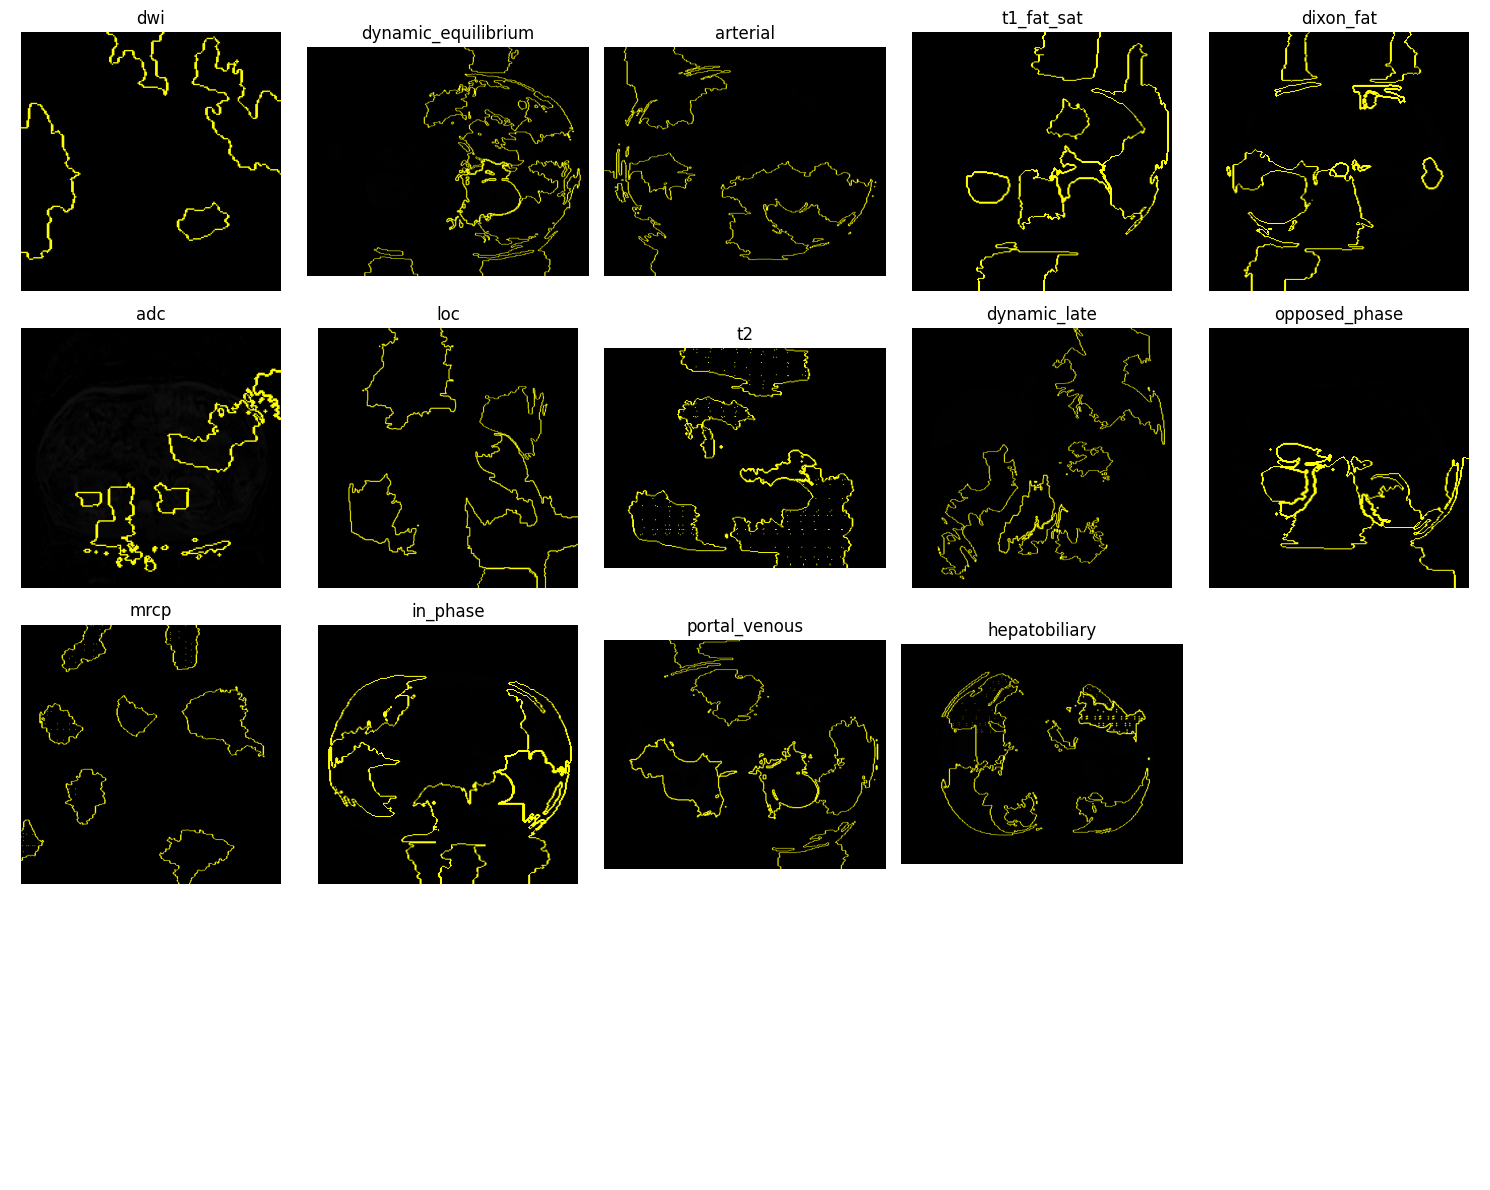

In [41]:
# Define the test transforms (same as used for model evaluation)
test_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to match the model input size
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# LIME explainer
explainer = lime_image.LimeImageExplainer()

# Function to run LIME and get the mask
def get_lime_mask(image, model, lime_predict_fn):
    # Apply the test transforms to the image
    image_pil = Image.fromarray(image).convert('RGB')  # Convert grayscale to RGB if necessary
    processed_image = test_transform(image_pil).unsqueeze(0)  # Add batch dimension

    # Move the processed image to the same device as the model
    processed_image = processed_image.to(device)  # Ensure it's on the same device (GPU or CPU)

    # Model prediction
    output = model(processed_image)
    _, predicted = torch.max(output, 1)

    # Prepare the image for LIME (convert back to numpy, remove batch dimension, and transpose)
    image_np = processed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Run LIME on the image
    explanation = explainer.explain_instance(image_np, lime_predict_fn, top_labels=5, hide_color=0, num_samples=1000)

    # Get the mask for the top predicted class
    _, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    return mask

# Set up the number of rows and columns for the grid and create a figure
n_cols = 5
n_rows = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))

# Flatten the axes for easier indexing
axes = axes.flatten()



# Inside the main loop:
for idx, (ax, (_, row)) in enumerate(zip(axes, each_type.iterrows())):
    image_path = row['fname']
    label = row['label']
    named_label = abd_label_dict[str(label)]['short']

    # Load the DICOM image
    ds = pydicom.dcmread(image_path)
    image = ds.pixel_array

    # Run LIME and get the mask
    lime_mask = get_lime_mask(image, model, lime_predict_fn)

    # Resize the LIME mask to match the original image dimensions
    if lime_mask.shape != image.shape:
        lime_mask_resized = resize(lime_mask, image.shape, preserve_range=True)
        # Convert the resized mask to integers
        lime_mask_resized = lime_mask_resized.astype(int)
    else:
        lime_mask_resized = lime_mask

    # Superimpose the LIME mask on the original image (before any transformations)
    superimposed_image = mark_boundaries(image, lime_mask_resized)

    # Display the image with the LIME mask
    ax.imshow(superimposed_image, cmap='gray')
    ax.set_title(named_label)
    ax.axis('off')  # Turn off the axis labels/ticks

# Hide any remaining empty subplots
for ax in axes[idx + 1:]:
    ax.axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

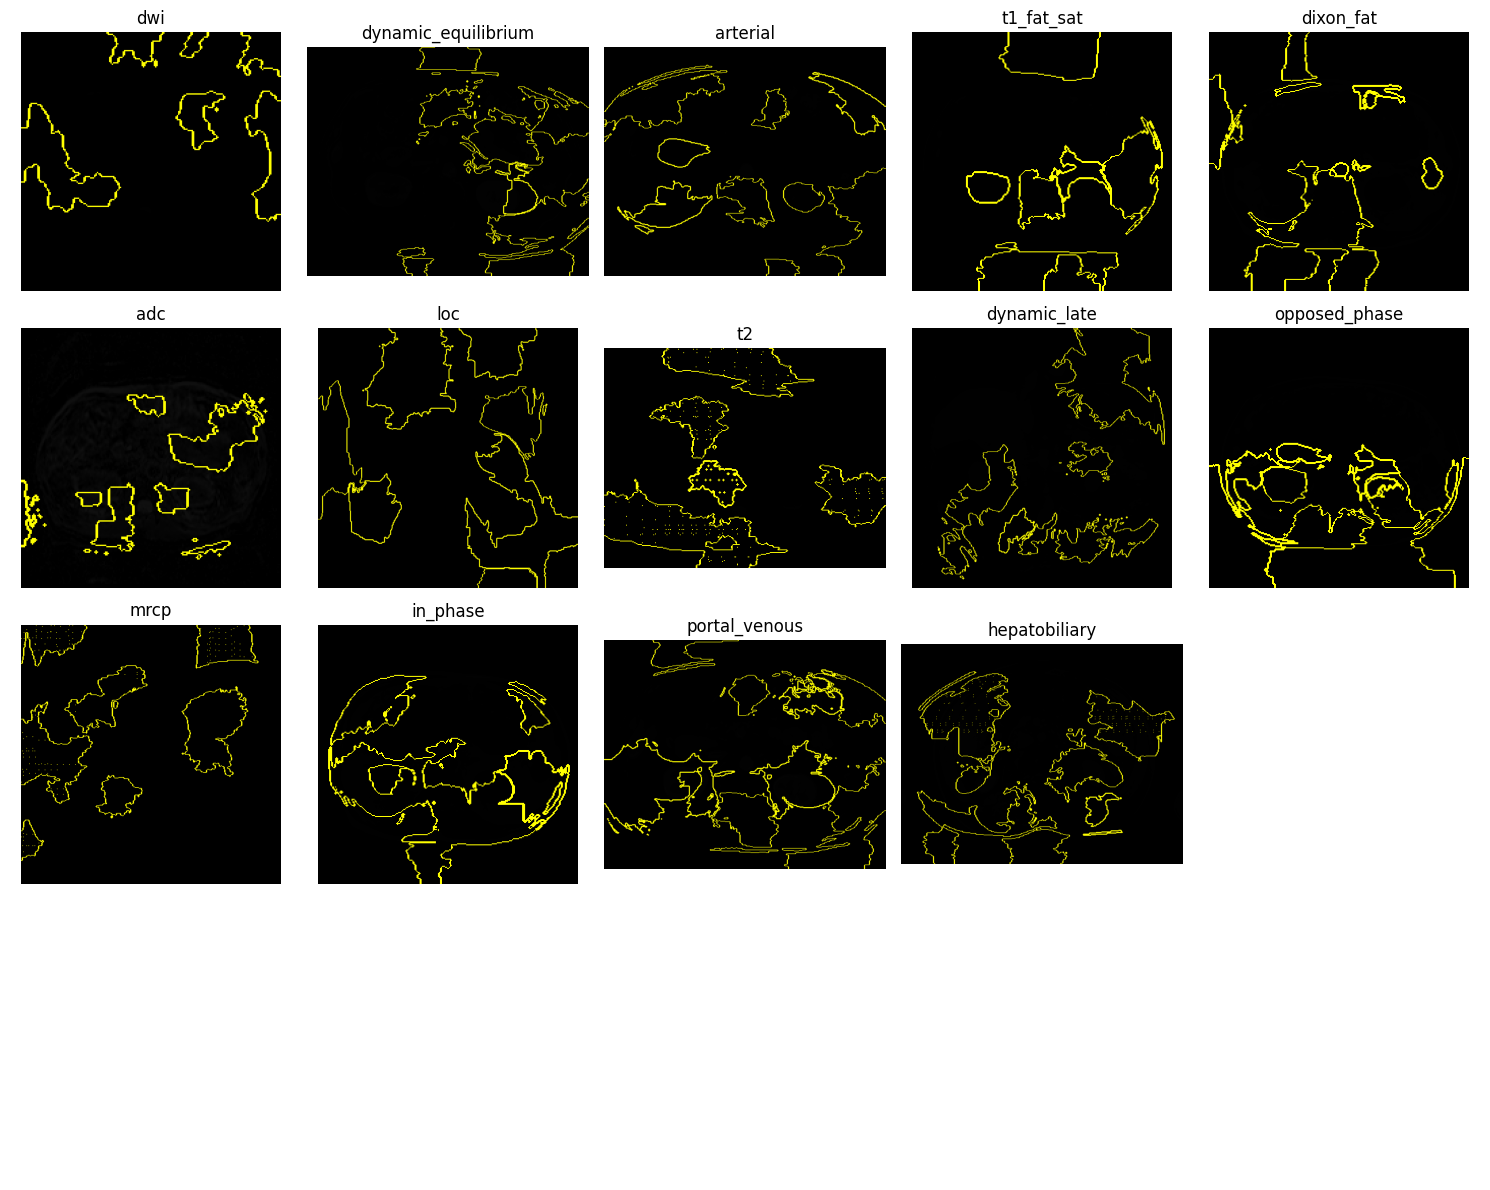

In [38]:

# Define the test transforms (same as used for model evaluation)
test_transform = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# LIME explainer
explainer = lime_image.LimeImageExplainer()

# Function to undo the normalization for visualization
def unnormalize(image_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_tensor = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
    image_tensor = image_tensor * std + mean  # Undo normalization
    image_tensor = np.clip(image_tensor, 0, 1)  # Clip to valid range
    return image_tensor

# Function to run LIME and get the mask
def get_lime_mask(image, model, lime_predict_fn):
    # Apply the test transforms to the image
    image_pil = Image.fromarray(image).convert('RGB')  # Convert grayscale to RGB if necessary
    processed_image = test_transform(image_pil).unsqueeze(0)  # Add batch dimension

    # Move the processed image to the same device as the model
    processed_image = processed_image.to(device)

    # Model prediction
    output = model(processed_image)
    _, predicted = torch.max(output, 1)

    # Prepare the image for LIME (convert back to numpy, remove batch dimension, and transpose)
    image_np = processed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Run LIME on the image
    explanation = explainer.explain_instance(image_np, lime_predict_fn, top_labels=5, hide_color=0, num_samples=1000)

    # Get the mask for the top predicted class
    _, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    return mask

# Set up the number of rows and columns for the grid and create a figure
n_cols = 5
n_rows = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Inside the main loop:
for idx, (ax, (_, row)) in enumerate(zip(axes, each_type.iterrows())):
    image_path = row['fname']
    label = row['label']
    named_label = abd_label_dict[str(label)]['short']

    # Load the DICOM image
    ds = pydicom.dcmread(image_path)
    image = ds.pixel_array

    # Run LIME and get the mask
    lime_mask = get_lime_mask(image, model, lime_predict_fn)

    # Resize the LIME mask to match the original image dimensions
    if lime_mask.shape != image.shape:
        lime_mask_resized = resize(lime_mask, image.shape, preserve_range=True)
        # Convert the resized mask to integers
        lime_mask_resized = lime_mask_resized.astype(int)
    else:
        lime_mask_resized = lime_mask

    # Superimpose the LIME mask on the original unprocessed DICOM image
    superimposed_image = mark_boundaries(image, lime_mask_resized)

    # Display the original unprocessed image with the LIME mask
    ax.imshow(superimposed_image, cmap='gray')
    ax.set_title(named_label)
    ax.axis('off')  # Turn off the axis labels/ticks

# Hide any remaining empty subplots
for ax in axes[idx + 1:]:
    ax.axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


I chose to explore LIME (Local Interpretable Model-agnostic Explanations) as it is often preferred for interpretability tasks in image classification due to several key factors.

1.   **Model-Agnostic and Flexible:** LIME works with any black-box model, including DenseNet. You don’t need to modify the model or rely on internal gradients (unlike some SHAP methods), making LIME highly flexible.

2. **Superpixel Explanations:** LIME operates by dividing the image into superpixels, which are groups of adjacent pixels that often share similar visual characteristics. By perturbing these superpixels and analyzing the effect on the model’s output, LIME offers an explanation of the regions in the image which are most important for the prediction.

3. **Localized Explanations:** LIME is particularly useful for generating local explanations, which means it focuses on explaining why the model made a particular prediction for a given image. This is useful when you want to understand individual classifications and explore specific image regions responsible for the decision.

4. **Customizable:** You can control how LIME perturbs the image (e.g., size of superpixels, number of perturbations) and adjust it to suit the complexity of the images.


5. **Visual Interpretability:** LIME generates intuitive, easy-to-visualize explanations by overlaying important superpixels on top of the original image. For image classification, this visual representation is often easier to interpret compared to the rule-based explanations of Anchors or the intricate pixel-wise attribution in SHAP.


Advantages of LIME Over Anchors or SHAP:

While Anchors provides rule-based explanations (e.g., "If this set of pixels is present, the model will always predict X"), LIME provides more detailed, graded explanations, showing how much each superpixel contributes to the final decision. This can be more insightful for image tasks where specific regions matter more than discrete "rules."

SHAP is generally slower than LIME, especially when applied to deep neural networks like DenseNet. SHAP calculates Shapley values, which can be computationally expensive because it considers all feature combinations. LIME, in contrast, is faster and less computationally intensive because it approximates the behavior of the model locally.

SHAP can give very precise pixel-level attributions, but these can be harder to interpret visually for non-technical users. LIME’s focus on superpixels gives you higher-level insights that are visually easier to comprehend.

Limitations of LIME:

One is that local explanations may not generalize.  Additionally, LIME creates a local surrogate model to explain the prediction, but these explanations are approximate and can vary with different perturbations. This means the results might not always be consistent across different runs, especially for images that are borderline cases.

LIME provides explanations for individual predictions, but it does not give you a global understanding of how the model behaves across the entire dataset, unlike SHAP, which can offer both global and local explanations.

Since LIME uses a linear surrogate model to approximate the complex decision boundary of DenseNet, it might oversimplify the true decision-making process of the neural network, especially for high-dimensional, non-linear image data.

LIME is slower than anchors for large images, and may require many perturbations to approximate the model’s behavior for a given image. For high-resolution images or large test sets, this can be computationally expensive and time-consuming, although it is typically faster than SHAP.


In [42]:
# Prediction function for Anchors
def predict_fn(images):
    # Convert to tensor and move to device
    images = torch.tensor(images).float().to(device)

    #print('in predict, images has shape', images.shape)


    # Get model outputs
    with torch.no_grad():
      outputs = model(images)
    #print('outputs has dimensions', outputs.shape)

    # Return softmax predictions
    preds = torch.nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    #print('preds:', preds, preds.shape)


    return preds



In [43]:

#Select an image from the test set and preprocess it
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)

# Get a single image and convert it to (height, width, channels)
image = inputs[0].cpu().numpy()
print('initial image has shape', image.shape)

# Initialize the AnchorImage explainer
# Here, we use (3, 299, 299) as image_shape since that's the size of a single image
explainer = AnchorImage(predict_fn, image_shape=(3, 299, 299))

# Run the Anchors explanation
explanation = explainer.explain(image)

print(explanation['segments'].shape)


# Convert the image shape to (299, 299, 3) for visualization
image = image.transpose(1, 2, 0)  # Convert to (299, 299, 3)
print('image shape is now', image.shape)
print('explanation segments shape:', explanation['segments'].shape)

# Visualize the explanation with mark_boundaries
plt.imshow(mark_boundaries(image, explanation['segments'].astype(int)))
plt.show()


# # Visualize the explanation with mark_boundaries
# plt.imshow(mark_boundaries(image, explanation['segments']))
# plt.show()

initial image has shape (3, 299, 299)
(3, 299)
image shape is now (299, 299, 3)
explanation segments shape: (3, 299)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 299 but corresponding boolean dimension is 3

torch.Size([3, 299, 299])

initial image has shape (3, 299, 299)


explanation segments shape: (3, 299)
explanation segments shape: (3, 299)
image shape is now (299, 299, 3)
resized segments shape: (299, 299)


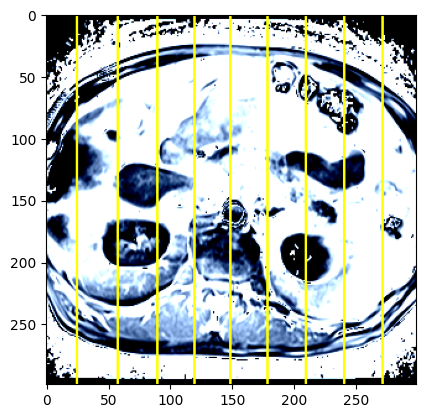

In [ ]:
# Select an image from the test set and preprocess it
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)

# Get a single image and convert it to (height, width, channels)
image = inputs[3].cpu().numpy()
print('initial image has shape', image.shape)

# Initialize the AnchorImage explainer
explainer = AnchorImage(predict_fn, image_shape=(3, 299, 299))

# Run the Anchors explanation
explanation = explainer.explain(image)

# Check the shape of explanation['segments']
print('explanation segments shape:', explanation['segments'].shape)

# Extract the segments from the explanation object
segments = explanation['segments']
print('explanation segments shape:', segments.shape)

# Resize explanation['segments'] to match the image dimensions (299, 299)
if segments.shape != (299, 299):
    resized_segments = resize(segments, (299, 299), preserve_range=True, anti_aliasing=True)
else:
    resized_segments = segments

# Convert the image shape to (299, 299, 3) for visualization
image = image.transpose(1, 2, 0)  # Convert to (299, 299, 3)
print('image shape is now', image.shape)
print('resized segments shape:', resized_segments.shape)

# Visualize the explanation with mark_boundaries
plt.imshow(mark_boundaries(image, resized_segments.astype(int)))
plt.show()

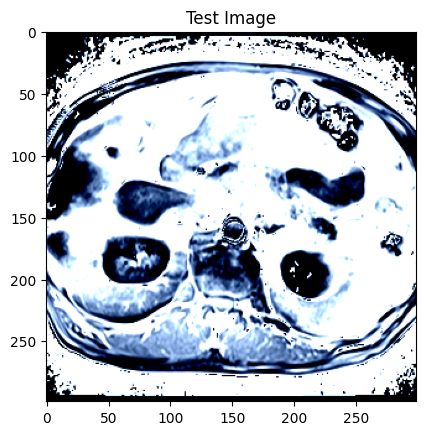

In [ ]:
plt.imshow(image, cmap='gray')
plt.title('Test Image')
plt.show()

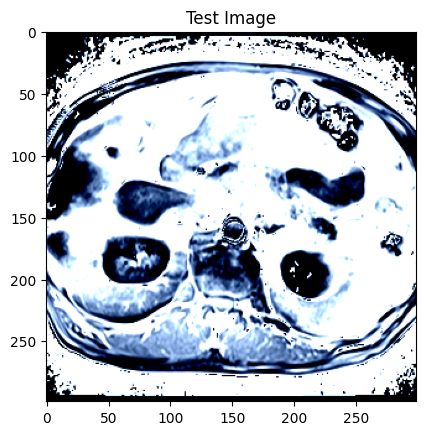

In [ ]:
plt.imshow(image, cmap='gray')
plt.title('Test Image')
plt.show()